In [1]:
!pip install fbprophet

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import numpy as np
sns.set()

from fbprophet import Prophet
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path = '/content/drive/My Drive/'
#file = 'SCADA_data_WT2339.csv'
file = 'SCADA_data_WT1158.csv'
df_raw = pd.read_csv(path+file,
                   low_memory=False)
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'], format="%Y/%m/%d %H:%M:%S")
df_raw = df_raw.sort_values(by='date_time')
df_raw.tail()

,id,ld_id,date_time,fake_data,TimeStamp,scadaplant,scadadevice,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContAlarmErrMean,ContAlarmErrSdev,ContAlarmErrMin,ContAlarmErrMax,ContAmbErrMean,ContAmbErrSdev,ContAmbErrMin,ContAmbErrMax,ContCurtailMean,ContCurtailSdev,ContCurtailMin,...,Top_Alm4Mean,Top_Alm4Sdev,Top_Alm4Min,Top_Alm4Max,Top_Alm6Mean,Top_Alm6Sdev,Top_Alm6Min,Top_Alm6Max,Top_Alm8Mean,Top_Alm8Sdev,Top_Alm8Min,Top_Alm8Max,Top_Alm9Mean,Top_Alm9Sdev,Top_Alm9Min,Top_Alm9Max,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,VelVientoPruebaMean,VelVientoPruebaSdev,VelVientoPruebaMin,VelVientoPruebaMax,YawMean,YawSdev,YawMin,YawMax
350497,38794727,1158,2019-10-28 01:10:00,0,NaN,NaN,NaN,600,219.040,4.61644,212.472,228.062,217.041,5.31354,209.418,228.544,219.068,4.58961,212.793,228.222,0.0,NaN,NaN,NaN,NaN,540424000.0,19906900.0,537402000.0,671620000.0,61998.0,0.0,61998.0,61998.0,519550.0,0.0,519550.0,519550.0,28591.0,0.0,28591.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-196.195,4.01937,-205.0,-186.0,929.680,0.739158,928.274,930.96,11.8760,0.055744,11.65,12.03,5.94040,0.459764,4.91560,7.30215,NaN,NaN,NaN,NaN,92.0373,1.825770,88.9706,95.000
350498,38794728,1158,2019-10-28 01:20:00,0,NaN,NaN,NaN,600,220.474,3.66752,214.561,228.705,217.424,5.05974,209.257,228.705,220.915,3.27884,214.400,228.222,0.0,NaN,NaN,NaN,NaN,544201000.0,29431300.0,537402000.0,671620000.0,61998.0,0.0,61998.0,61998.0,519550.0,0.0,519550.0,519550.0,28591.0,0.0,28591.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-207.354,11.77210,-230.0,-187.0,944.288,30.266700,925.800,1030.80,12.0688,0.400700,11.73,13.29,6.44443,0.520010,5.07413,8.00390,NaN,NaN,NaN,NaN,99.5851,2.492290,94.0000,104.000
350499,38794729,1158,2019-10-28 01:30:00,0,NaN,NaN,NaN,600,221.066,3.91435,215.204,228.544,217.270,5.66924,209.257,228.865,221.071,3.72296,215.686,228.222,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,61998.0,0.0,61998.0,61998.0,519550.0,0.0,519550.0,519550.0,28591.0,0.0,28591.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-234.552,6.59522,-250.0,-221.0,1022.750,46.086500,926.760,1100.28,13.1189,0.612581,11.83,14.19,7.00764,0.581380,5.78889,8.68954,NaN,NaN,NaN,NaN,104.0570,0.541379,103.0000,105.000
350500,38794730,1158,2019-10-28 01:40:00,0,NaN,NaN,NaN,600,219.960,4.51391,209.257,228.383,217.322,5.49087,209.257,228.865,220.046,4.42134,209.097,228.062,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,61998.0,0.0,61998.0,61998.0,519550.0,0.0,519550.0,519550.0,28591.0,0.0,28591.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-235.419,4.62904,-246.0,-219.0,1038.500,53.447400,924.360,1129.68,13.3177,0.680880,11.88,14.61,7.16470,0.562280,5.70177,8.58627,NaN,NaN,NaN,NaN,104.0420,0.137679,104.0000,104.738
350501,38794731,1158,2019-10-28 01:50:00,0,NaN,NaN,NaN,600,219.016,4.53079,212.311,228.222,216.356,5.18688,209.418,228.705,219.020,4.56845,212.311,227.901,0.0,NaN,NaN,NaN,NaN,556473000.0,46859700.0,537402000.0,671620000.0,61998.0,0.0,61998.0,61998.0,519550.0,0.0,519550.0,519550.0,28591.0,0.0,28591.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-233.778,3.81300,-245.0,-223.0,1079.630,80.189400,960.480,1238.16,13.8593,1.051310,12.39,16.10,7.34039,0.666698,5.58140,9.34138,NaN,NaN,NaN,NaN,124.6490,11.469700,104.0000,138.315


In [4]:
df_raw.head()

,id,ld_id,date_time,fake_data,TimeStamp,scadaplant,scadadevice,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContAlarmErrMean,ContAlarmErrSdev,ContAlarmErrMin,ContAlarmErrMax,ContAmbErrMean,ContAmbErrSdev,ContAmbErrMin,ContAmbErrMax,ContCurtailMean,ContCurtailSdev,ContCurtailMin,...,Top_Alm4Mean,Top_Alm4Sdev,Top_Alm4Min,Top_Alm4Max,Top_Alm6Mean,Top_Alm6Sdev,Top_Alm6Min,Top_Alm6Max,Top_Alm8Mean,Top_Alm8Sdev,Top_Alm8Min,Top_Alm8Max,Top_Alm9Mean,Top_Alm9Sdev,Top_Alm9Min,Top_Alm9Max,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,VelVientoPruebaMean,VelVientoPruebaSdev,VelVientoPruebaMin,VelVientoPruebaMax,YawMean,YawSdev,YawMin,YawMax
0,26116846,1158,2013-01-01 01:00:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26116847,1158,2013-01-01 01:10:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26116848,1158,2013-01-01 01:20:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26116849,1158,2013-01-01 01:30:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26116850,1158,2013-01-01 01:40:00,0,NaN,NaN,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


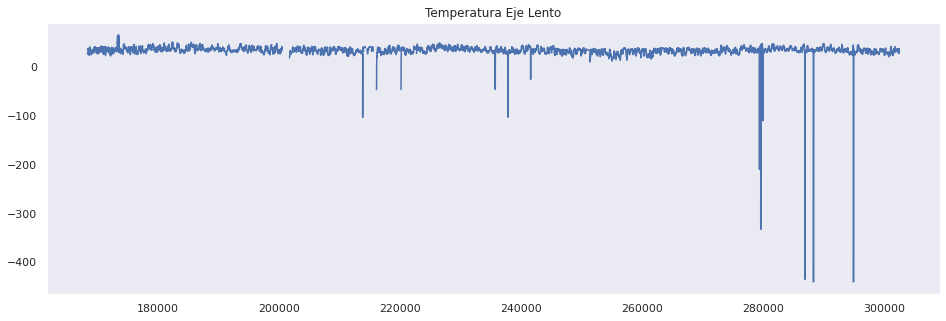

In [5]:
plt.subplots(1, figsize = (16, 5))
plt.grid()
plt.title('Temperatura Eje Lento')
#plt.plot(df_raw['TempEjeLento_1'].rolling(window=150).median())
plt.plot(df_raw['TempEjeLento_1'])

In [6]:
train_dataset = df_raw[['date_time', 'TempEjeLento_1','TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']]
train_dataset.columns = ["ds", "y",'TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']
train_dataset=train_dataset.dropna()
train_dataset.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
168336,2016-03-15 01:00:00,25.8679,12.0984,3.22780,3.74009,0.432272
168337,2016-03-15 01:10:00,25.7970,11.9824,3.10312,3.96989,0.500724
168338,2016-03-15 01:20:00,25.7544,11.9199,3.16720,4.11710,0.486258
168339,2016-03-15 01:30:00,25.9314,11.7801,3.12525,4.42660,0.507280
168340,2016-03-15 01:40:00,25.9139,11.6479,3.17962,4.67589,0.565216


In [7]:
def remove_outliers(df):
    return df[np.abs(df['y']-df['y'].mean())<=(3*df['y'].std())] 

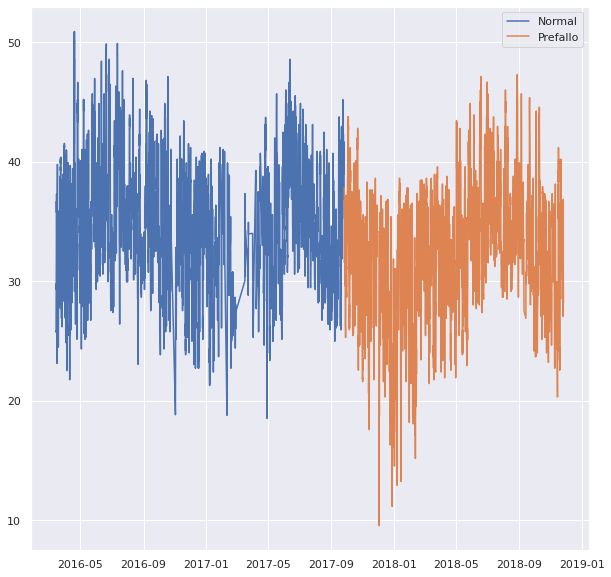

In [8]:
date = '2017-09-26'
date_fail = '2018-03-26'
data_1 = train_dataset[(train_dataset['ds'] < date)]
data_1 = remove_outliers(data_1)

data_2 = train_dataset[(train_dataset['ds'] > date)]
data_2 = remove_outliers(data_2)

data_test = train_dataset[(train_dataset['ds'] < date_fail)]
#data_test = data_test[(data_test['ds'] < date_fail)]
data_test = remove_outliers(data_test)
plt.figure(figsize=(10,10))
plt.plot(data_1['ds'],data_1['y'],label='Normal')
plt.plot(data_2['ds'],data_2['y'],label='Prefallo')
plt.legend()
plt.show()

In [9]:
#prophet_basic = Prophet(yearly_seasonality=True)
prophet_basic = Prophet()
prophet_basic.add_regressor('TempAmbMean')
prophet_basic.add_regressor('IndTurbulMean')
prophet_basic.add_regressor('VelVientoMean')
prophet_basic.add_regressor('VelVientoSdev')
prophet_basic.fit(data_1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


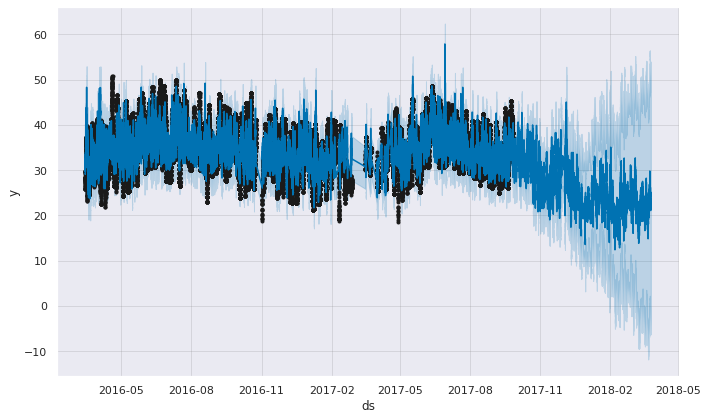

In [10]:
forecast=prophet_basic.predict(data_test.drop(columns="y"))

#Plotting the predicted data
fig1 =prophet_basic.plot(forecast)

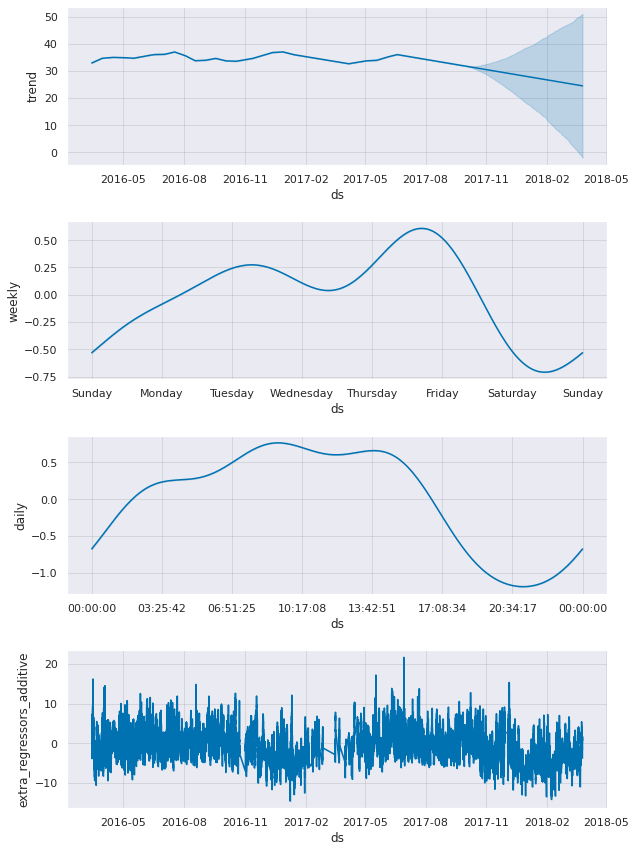

In [11]:
fig1 = prophet_basic.plot_components(forecast)

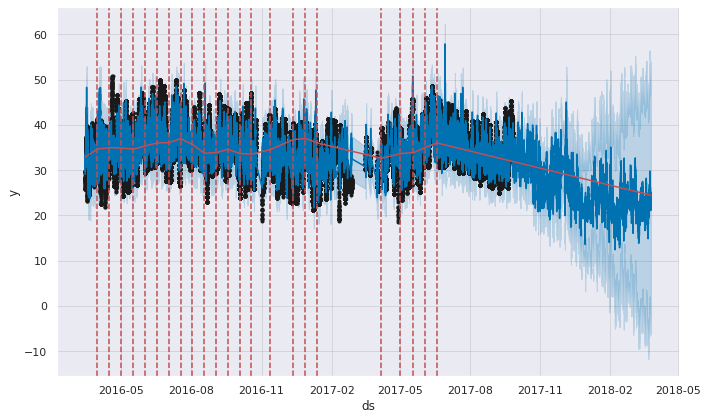

In [12]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
95378,2018-03-25 23:10:00,24.473836,-1.541343,53.138816,-1.995587,50.988054,2.199816,2.199816,2.199816,-2.172878,-2.172878,-2.172878,1.843162,1.843162,1.843162,-0.195740,-0.195740,-0.195740,0.643671,0.643671,0.643671,-0.932770,-0.932770,-0.932770,1.674361,1.674361,1.674361,-0.097920,-0.097920,-0.097920,0.0,0.0,0.0,25.117507
95379,2018-03-25 23:20:00,24.473550,-2.633128,51.417004,-1.998631,50.989096,2.186328,2.186328,2.186328,-2.145150,-2.145150,-2.145150,1.404971,1.404971,1.404971,-0.774684,-0.774684,-0.774684,-0.312084,-0.312084,-0.312084,-0.887905,-0.887905,-0.887905,0.671465,0.671465,0.671465,-0.095645,-0.095645,-0.095645,0.0,0.0,0.0,24.161466
95380,2018-03-25 23:30:00,24.473264,-2.445980,52.804367,-2.001675,50.990139,2.616754,2.616754,2.616754,-2.172087,-2.172087,-2.172087,1.802844,1.802844,1.802844,-0.995435,-0.995435,-0.995435,0.318956,0.318956,0.318956,-0.839748,-0.839748,-0.839748,1.252076,1.252076,1.252076,-0.093372,-0.093372,-0.093372,0.0,0.0,0.0,24.792220
95381,2018-03-25 23:40:00,24.472978,-2.716998,51.703178,-2.004719,50.991182,1.514398,1.514398,1.514398,-2.236122,-2.236122,-2.236122,1.764292,1.764292,1.764292,-0.282795,-0.282795,-0.282795,-0.119873,-0.119873,-0.119873,-0.788544,-0.788544,-0.788544,0.759774,0.759774,0.759774,-0.091103,-0.091103,-0.091103,0.0,0.0,0.0,24.353105
95382,2018-03-25 23:50:00,24.472692,-3.053509,52.285042,-2.007763,50.992225,2.167807,2.167807,2.167807,-2.300155,-2.300155,-2.300155,1.648584,1.648584,1.648584,-0.590531,-0.590531,-0.590531,0.102274,0.102274,0.102274,-0.734596,-0.734596,-0.734596,0.925705,0.925705,0.925705,-0.088836,-0.088836,-0.088836,0.0,0.0,0.0,24.574965


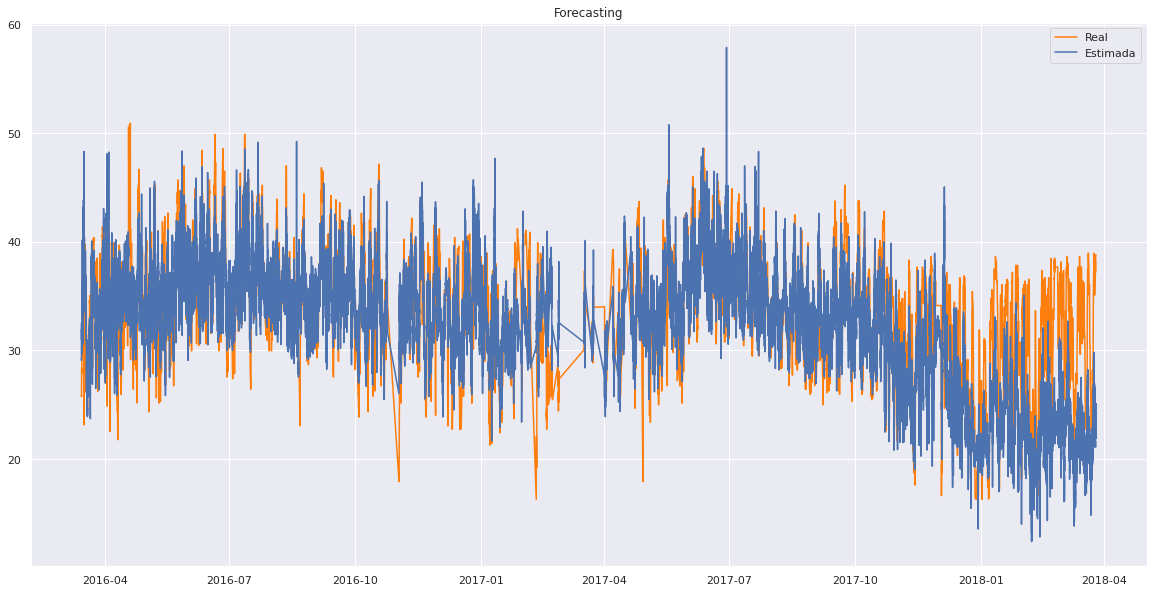

In [14]:
plt.figure(figsize=(20,10))
#plt.plot(forecast['ds'],forecast['yhat_lower'],'-r',label='Confianza')
#plt.plot(forecast['ds'],forecast['yhat_upper'],'-r')
plt.plot(data_test['ds'],data_test['y'],'tab:orange',label='Real')
plt.plot(forecast['ds'],forecast['yhat'],'b',label='Estimada')
#plt.plot(data_1['ds'],data_1['y'],'c')
plt.legend()
plt.title('Forecasting')
plt.show()

In [15]:
import numpy as np
forecast['error']= data_test['y']-forecast['yhat']

In [16]:
data_test.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
168336,2016-03-15 01:00:00,25.8679,12.0984,3.22780,3.74009,0.432272
168337,2016-03-15 01:10:00,25.7970,11.9824,3.10312,3.96989,0.500724
168338,2016-03-15 01:20:00,25.7544,11.9199,3.16720,4.11710,0.486258
168339,2016-03-15 01:30:00,25.9314,11.7801,3.12525,4.42660,0.507280
168340,2016-03-15 01:40:00,25.9139,11.6479,3.17962,4.67589,0.565216


In [17]:
forecast['y_true'] = data_test['y'].values
forecast['error'] = forecast['y_true']-forecast['yhat']

In [18]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,error,y_true
0,2016-03-15 01:00:00,32.908921,24.729173,33.796851,32.908921,32.908921,-1.011868,-1.011868,-1.011868,-1.285655,-1.285655,-1.285655,-1.720733,-1.720733,-1.720733,0.363687,0.363687,0.363687,-3.720282,-3.720282,-3.720282,-0.316214,-0.316214,-0.316214,-3.654569,-3.654569,-3.654569,0.250501,0.250501,0.250501,0.0,0.0,0.0,29.188639,-3.320739,25.8679
1,2016-03-15 01:10:00,32.909698,24.175326,33.440844,32.909698,32.909698,-1.172794,-1.172794,-1.172794,-1.317281,-1.317281,-1.317281,-1.593812,-1.593812,-1.593812,0.277893,0.277893,0.277893,-3.811019,-3.811019,-3.811019,-0.256830,-0.256830,-0.256830,-3.805994,-3.805994,-3.805994,0.251804,0.251804,0.251804,0.0,0.0,0.0,29.098678,-3.301678,25.7970
2,2016-03-15 01:20:00,32.910475,24.467492,34.006035,32.910475,32.910475,-1.090085,-1.090085,-1.090085,-1.334321,-1.334321,-1.334321,-1.512506,-1.512506,-1.512506,0.296024,0.296024,0.296024,-3.587009,-3.587009,-3.587009,-0.199194,-0.199194,-0.199194,-3.640889,-3.640889,-3.640889,0.253075,0.253075,0.253075,0.0,0.0,0.0,29.323466,-3.569066,25.7544
3,2016-03-15 01:30:00,32.911252,24.483875,34.002206,32.911252,32.911252,-1.144231,-1.144231,-1.144231,-1.372436,-1.372436,-1.372436,-1.341567,-1.341567,-1.341567,0.269676,0.269676,0.269676,-3.478072,-3.478072,-3.478072,-0.143826,-0.143826,-0.143826,-3.588557,-3.588557,-3.588557,0.254311,0.254311,0.254311,0.0,0.0,0.0,29.433179,-3.501779,25.9314
4,2016-03-15 01:40:00,32.912029,25.164247,34.377803,32.912029,32.912029,-1.074055,-1.074055,-1.074055,-1.408479,-1.408479,-1.408479,-1.203881,-1.203881,-1.203881,0.197062,0.197062,0.197062,-3.325044,-3.325044,-3.325044,-0.091205,-0.091205,-0.091205,-3.489353,-3.489353,-3.489353,0.255513,0.255513,0.255513,0.0,0.0,0.0,29.586984,-3.673084,25.9139


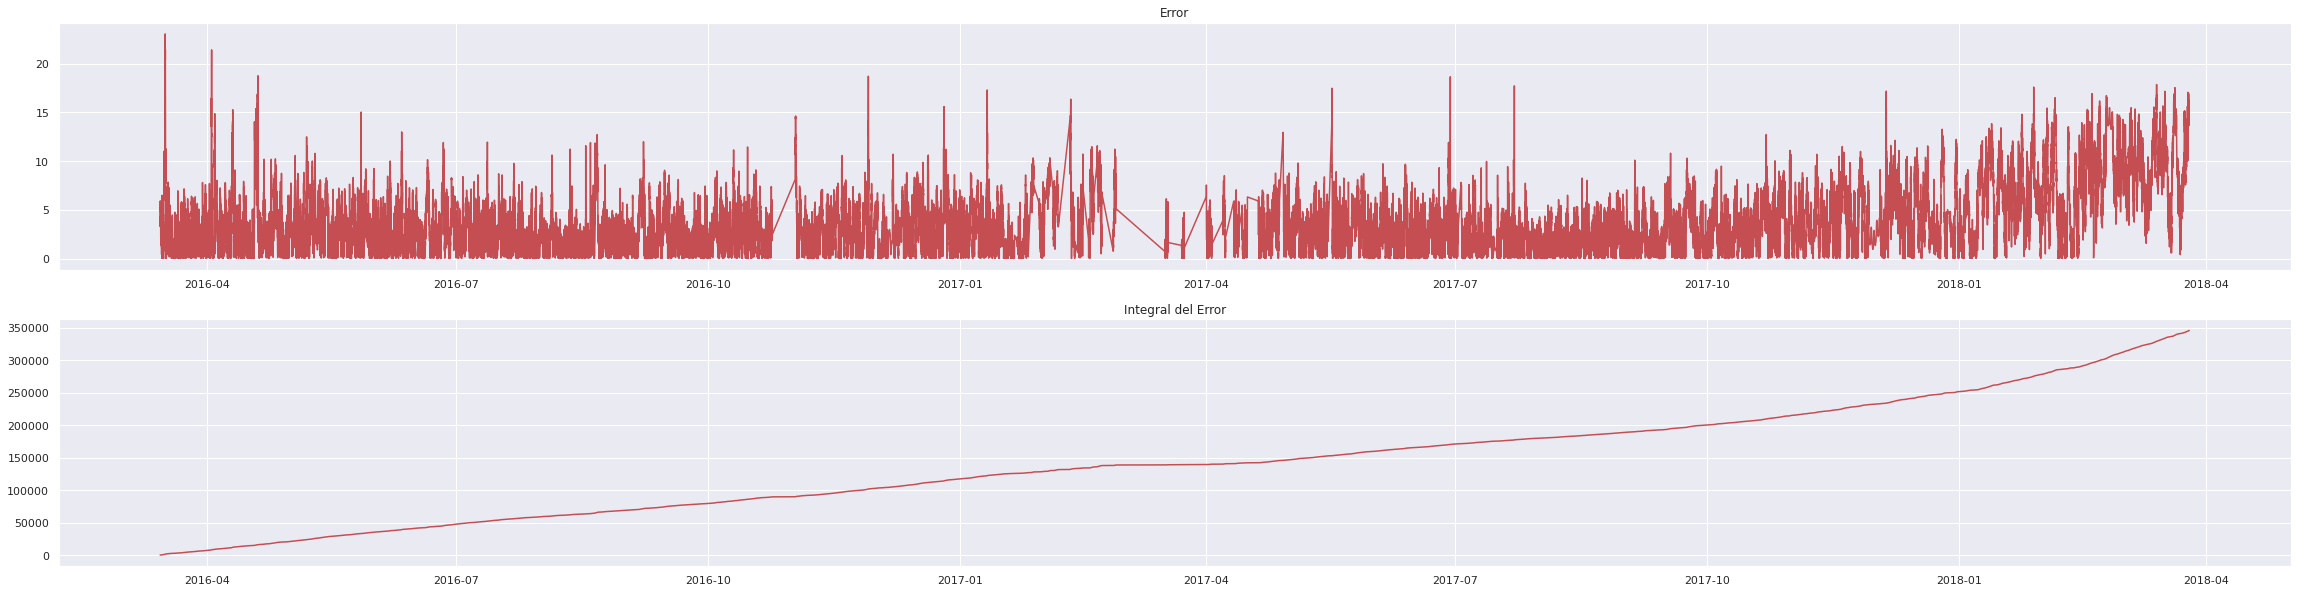

In [19]:
plt.figure(figsize=(40,10))
plt.subplot(211)
plt.title('Error')
plt.plot(forecast['ds'],forecast['error'].abs(),'r')
plt.subplot(212)
plt.title('Integral del Error')
plt.plot(forecast['ds'],forecast['error'].abs().cumsum(),'r')

plt.show()

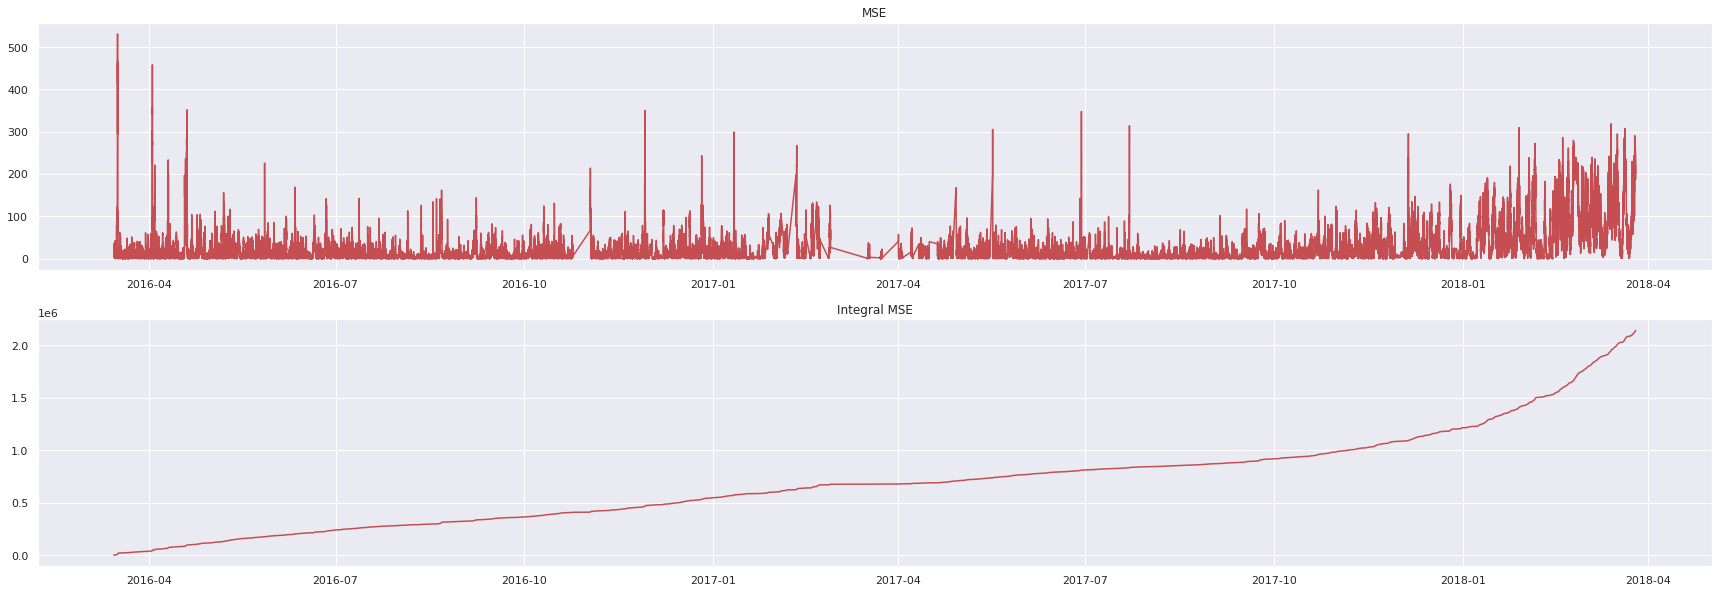

In [20]:
signal = forecast['error']**2
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.plot(forecast['ds'],signal,'r')
plt.title('MSE')
plt.subplot(212)
signal=forecast['error']**2
plt.plot(forecast['ds'],signal.cumsum(),'r')
plt.title('Integral MSE')
plt.show()